# Volume 4: Image Processing
    <Name>
    <Class>
    <Date>

In [31]:
import numpy as np
from numpy.random import randint
import matplotlib.pyplot as plt
from imageio.v3 import imread
from skimage import io, color
import heapq

# Load Images

In [23]:
# Load in the image.
image = imread('balloons_color.jpg', mode='F') * 1./255

# Create the noisy image by altering pixels from the original image.
noisy_image = image.copy()
x, y = image.shape
for i in range(x*y//50):
	noisy_image[randint(x), randint(y)] = (127 + randint(127)) * 1./255

# Problem 1

Finish the following function that implements the anisotropic diffusion algorithm.
Use the padded array technique to deal with the edges of the image.

Run your function on the noisy image with $\sigma=.1$, $\lambda=.25$, $N=20$, and $g(x)=e^{-\left(\frac{x}{\sigma}\right)^2}$.
Display the original image, the noisy image, and the cleaned image.
Explain why anisotropic diffusion does not smooth out the noise.

In [19]:
def anis_diff(U, N, g, lambda_=0.25):
    """
    Run the Anisotropic Diffusion differencing scheme on an image.

    Parameters:
        U ((m,n) ndarray): grayscale image.
        N (int): number of iterations.
        g (callable): diffusion function.
        lambda_ (float): scaling coefficient.

    Returns:
        ((m,n) ndarray): the processed grayscale image.
    """

    for i in range(N):
        U_pad = np.pad(U, mode='edge', pad_width=1)
        t1 = g(np.abs(U_pad[:-2, 1:-1] - U_pad[1:-1, 1:-1]))*(U_pad[:-2, 1:-1] - U_pad[1:-1, 1:-1])
        t2 = g(np.abs(U_pad[2:, 1:-1]  - U_pad[1:-1, 1:-1]))*(U_pad[2:, 1:-1]  - U_pad[1:-1, 1:-1])
        t3 = g(np.abs(U_pad[1:-1, :-2] - U_pad[1:-1, 1:-1]))*(U_pad[1:-1, :-2] - U_pad[1:-1, 1:-1])
        t4 = g(np.abs(U_pad[1:-1, 2:] - U_pad[1:-1, 1:-1]))*(U_pad[1:-1, 2:] - U_pad[1:-1, 1:-1])
        U = U_pad[1:-1, 1:-1] + lambda_*(t1 + t2 + t3 + t4)
    return U

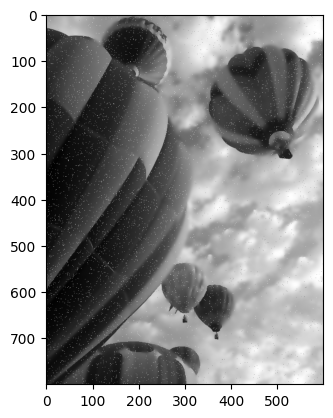

In [20]:
p1balloons = noisy_image.copy()
g = lambda x: np.exp(-(x/0.1)**2)
g = np.vectorize(g)
cleaned_image = anis_diff(p1balloons, 20, lambda_=0.25, g=g)
plt.imshow(cleaned_image, cmap='gray')
plt.show()

anisotropic diffusion does not smooth out the noise because it will conside places where noise is very visible edges and only averages it making a very fuzzy image

# Problem 2

Finish the following function that implements the mimimum-biased finite difference scheme.
Run your function on the noisy image with $\lambda=0.25$.
Experiment with the number of iterations until the resulting image looks close to the original image.
Display the original image, the noisy image, and the cleaned image.

In [34]:
def min_bias(U, N, lambda_=0.25):
    """
    Run the Minimum Bias differencing scheme on an image.

    Parameters:
        U ((m,n) ndarray): grayscale image.
        N (int): number of iterations.
        lambda_ (float): scaling coefficient.

    Returns:
        ((m,n) ndarray): the processed grayscale image.
    """
    m, n = U.shape
    # calculate G

    for i in range(N):
        U_pad = np.pad(U, mode='edge', pad_width=1)
        G_temp = (np.abs(U_pad[:-2, 1:-1]-U_pad[1:-1, 1:-1]), np.abs(U_pad[2:, 1:-1]-U_pad[1:-1, 1:-1]), np.abs(U_pad[1:-1, :-2]-U_pad[1:-1, 1:-1]), np.abs(U_pad[1:-1, 2:]-U_pad[1:-1, 1:-1]))
        G_hat = np.zeros((m,n))
        for i in range(m):
          for j in range(n):
              vals = [
            G_temp[0][i, j],
            G_temp[1][i, j],
            G_temp[2][i, j],
            G_temp[3][i, j]
        ]
              G_hat[i, j] = np.mean(heapq.nsmallest(2, vals))
        U = U_pad[1:-1, 1:-1] + lambda_*G_hat*(U_pad[:-2, 1:-1]+U_pad[2:, 1:-1]+U_pad[1:-1, :-2]+U_pad[1:-1, 2:] - 4*U_pad[1:-1, 1:-1])
    return U

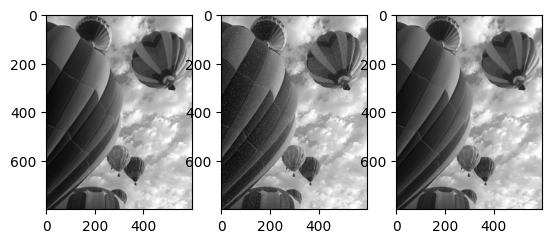

In [35]:
p2balloons = noisy_image.copy()
cleaned_image = min_bias(p2balloons, 20, lambda_=0.25)
plt.subplot(1,3,1)
plt.imshow(cleaned_image, cmap='gray')
plt.subplot(1,3,2)
plt.imshow(p2balloons, cmap='gray')
plt.subplot(1,3,3)
plt.imshow(image, cmap='gray')
plt.show()

# Problem 3

Finish the following function that implements the gradient descent finite diffrerence scheme.
Run your function on the noisy image with $\Delta t =$ 1e-3, $\lambda = 40,$ $\Delta x = 1,$ and $\Delta y = 1$.
Experiment with the number of iterations until the noise is hard to see.
Display the original image, the noisy image, and the cleaned image.

In [27]:
def grad_desc(U, N, lambda_, delta_t, delta_x=1, delta_y=1):
    """
    Run the Gradient Descent differencing scheme on an image.

    Parameters:
        U ((m,n) ndarray): grayscale image.
        N (int): number of iterations.
        lambda_ (float): scaling coefficient.
        delta_t (float): change in time.
        delta_x (float): change in x.
        delta_y (float): change in y.

    Returns:
        ((m,n) ndarray): the processed grayscale image.
    """
    f = U.copy()
    for i in range(N):
      U_pad = np.pad(U, mode='edge', pad_width=1)

      t1 = (U_pad[:-2, 1:-1] -2*U_pad[1:-1, 1:-1] + U_pad[2:, 1:-1])/delta_x**2
      t2 = (U_pad[1:-1, :-2] - 2*U_pad[1:-1, 1:-1] + U_pad[1:-1, 2:])/delta_y**2
      U = U_pad[1:-1, 1:-1] - delta_t * (U_pad[1:-1, 1:-1] - f - lambda_ * (t1+t2))
    return U

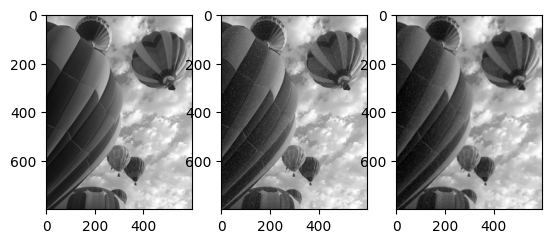

In [29]:
p3balloons = noisy_image.copy()
cleaned_image = grad_desc(p3balloons, N = 20, lambda_=40, delta_t=1e-3, delta_x=1, delta_y=1)
plt.subplot(1,3,1)
plt.imshow(image, cmap='gray')
plt.subplot(1,3,2)
plt.imshow(p3balloons, cmap='gray')
plt.subplot(1,3,3)
plt.imshow(cleaned_image, cmap='gray')
plt.show()

# Problem 4

Derive the update scheme for the total variations method.
Then, finish the following function that implements this method.
Use a centered difference to approximate the values for $u_{x}$ and $u_{y}$.
Run your function on the noisy image using $\Delta t =$ 1e-3, $\lambda = 1, \epsilon =$ 1e-6, $\Delta x = 1,$ and $ \Delta y = 1$.
Experiment with the number of iterations until the resulting image looks close to the original image.
Display the original image, the noisy image, and the cleaned image.

In [38]:
def total_var(U, N, lambda_, epsilon, delta_t, delta_x=1, delta_y=1):
    """
    Run the Total Variations differencing scheme on an image.

    Parameters:
        U ((m,n) ndarray): grayscale image.
        N (int): number of iterations.
        lambda_ (float): scaling coefficient.
        epsilon (float): adjustment for denominator.
        delta_t (float): change in time.
        delta_x (float): change in x.
        delta_y (float): change in y.

    Returns:
        ((m,n) ndarray): the processed grayscale image.
    """
    U = U.astype(float)
    f = U.copy()
    for i in range(N):
      U_pad = np.pad(U, mode='edge', pad_width=1)
      U_x = (U_pad[2:,1:-1] - U_pad[:-2,1:-1])/(2*delta_x)
      pad_U_x = np.pad(U_x, mode="edge", pad_width=1)
      U_xy = (pad_U_x[1:-1, :-2] - pad_U_x[1:-1, 2:])/(2*delta_y)
      U_y = (U_pad[1:-1,2:] - U_pad[1:-1,:-2])/(2*delta_y)
      U_xx = (U_pad[:-2, 1:-1] - 2 * U_pad[1:-1, 1:-1] + U_pad[2:, 1:-1]) / (delta_x**2)
      U_yy = (U_pad[1:-1,2:] - 2*U_pad[1:-1,1:-1] + U_pad[1:-1,:-2]) / (delta_y**2)
      grad_sq = U_x**2 + U_y**2
      denom = (grad_sq + epsilon)**1.5
      TV_term = (U_xx*U_y**2 + U_yy*U_x**2 - 2*U_x*U_y*U_xy) / denom
      RHS = -lambda_ * (U-f) + TV_term
      U = U + delta_t * RHS
    return U

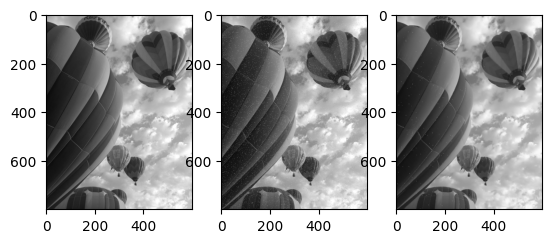

In [39]:
p4balloons = noisy_image.copy()
cleaned_image = total_var(p4balloons, N = 20, lambda_ = 1, epsilon = 1e-6, delta_t = 1e-3, delta_x = 1, delta_y = 1)
plt.subplot(1,3,1)
plt.imshow(image, cmap='gray')
plt.subplot(1,3,2)
plt.imshow(p3balloons, cmap='gray')
plt.subplot(1,3,3)
plt.imshow(cleaned_image, cmap='gray')
plt.show()